In [1]:
#pytorch
import torch #pytorch
import torchvision #pytorch datasets and vision functions
import torchvision.transforms as transforms
from torchvision.transforms import v2 #v2 transforms
import torch.optim as optim
import torch.nn as nn #neural network
from torch.utils.data import DataLoader #for val split

from tqdm.notebook import tqdm

#sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#images and plotting
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

#dataframes and arrays
import numpy as np

#GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using:', device)

Using: cuda


Load Data

In [2]:
transforms = v2.Compose([
    v2.Resize(size=(224,224)),
    v2.RandomHorizontalFlip(p=.3),
    #v2.RandomVerticalFlip(p=.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, .5, .5], std=[0.5, .5, .5])
    ])

testtransforms = v2.Compose([
    v2.Resize(size=(224,224)),
    #v2.RandomHorizontalFlip(p=.3),
    #v2.RandomVerticalFlip(p=.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, .5, .5], std=[0.5, .5, .5])
    ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=testtransforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# get some random training images
#dataiter = iter(trainloader)
#images, labels = next(dataiter)


Files already downloaded and verified
Files already downloaded and verified


Resnet-18

In [3]:
#from https://medium.com/analytics-vidhya/resnet-understand-and-implement-from-scratch-d0eb9725e0db
class ResNet18(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18, self).__init__()
        
        self.dropout_percentage = 0.5
        self.relu = nn.ReLU()
        
        # BLOCK-1 (starting block) input=(224x224) output=(56x56)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))
        
        # BLOCK-2 (1) input=(56x56) output = (56x56)
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-2 (2)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-3 (1) input=(56x56) output = (28x28)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-4 (1) input=(28x28) output = (14x14)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)
        self.concat_adjust_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout4_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)
        self.dropout4_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-5 (1) input=(14x14) output = (7x7)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)
        self.concat_adjust_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout5_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)
        self.dropout5_2 = nn.Dropout(p=self.dropout_percentage)
        
        # Final Block input=(7x7) 
        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), stride=(1,1))
        self.fc = nn.Linear(in_features=1*1*512, out_features=1000)
        self.out = nn.Linear(in_features=1000, out_features=n_classes)
        # END
    
    def forward(self, x):
        
        # block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)
        
        
        # block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    # conv2_1 
        x = self.batchnorm2_1_2(self.conv2_1_2(x))                 # conv2_1
        x = self.dropout2_1(x)
        # block2 - Adjust - No adjust in this layer as dimensions are already same
        # block2 - Concatenate 1
        op2_1 = self.relu(x + op1)
        # block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(op2_1)))  # conv2_2 
        x = self.batchnorm2_2_2(self.conv2_2_2(x))                 # conv2_2
        x = self.dropout2_2(x)
        # op - block2
        op2 = self.relu(x + op2_1)
    
        
        # block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
        x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1
        x = self.dropout3_1(x)
        # block3 - Adjust
        op2 = self.concat_adjust_3(op2) # SKIP CONNECTION
        # block3 - Concatenate 1
        op3_1 = self.relu(x + op2)
        # block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3_1)))  # conv3_2
        x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2 
        x = self.dropout3_2(x)
        # op - block3
        op3 = self.relu(x + op3_1)
        
        
        # block4 - 1[Convolition block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
        x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1
        x = self.dropout4_1(x)
        # block4 - Adjust
        op3 = self.concat_adjust_4(op3) # SKIP CONNECTION
        # block4 - Concatenate 1
        op4_1 = self.relu(x + op3)
        # block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4_1)))  # conv4_2
        x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2
        x = self.dropout4_2(x)
        # op - block4
        op4 = self.relu(x + op4_1)

        
        # block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1
        x = self.dropout5_1(x)
        # block5 - Adjust
        op4 = self.concat_adjust_5(op4) # SKIP CONNECTION
        # block5 - Concatenate 1
        op5_1 = self.relu(x + op4)
        # block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(op5_1)))  # conv5_2
        x = self.batchnorm5_2_1(self.conv5_2_1(x))                 # conv5_2
        x = self.dropout5_2(x)
        # op - block5
        op5 = self.relu(x + op5_1)


        # FINAL BLOCK - classifier 
        x = self.avgpool(op5)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc(x))
        x = self.out(x)

        return x

In [4]:
#training from https://www.kaggle.com/code/modojj/resnet18-from-scratch-pytorch
# TESTING IF THE MODEL IS WORKING CORRECTLY
model1 = ResNet18(100).to(device)
data = torch.randn(64, 3, 224, 224).to(device)
print(model1(data).shape)

torch.Size([64, 100])


In [5]:
print(model1)

ResNet18(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv2_1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_1): Dropout(p=0.5, inplace=False)
  (conv2_2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_2_2): BatchNo

In [9]:
train, val = torch.utils.data.random_split(trainset, [45000, 5000]) #45,000 training, 5000 validation
train_loader = DataLoader(dataset=train, batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val, batch_size=100, shuffle=True)

In [10]:
n_classes = len(set(trainset.targets)) #10 classes
n_batches = len(train_loader)

model = ResNet18(n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-6)


In [11]:

epochs = 100
train_accuracy_list=[]
val_accuracy_list=[]
#save best model
best_val_accuracy = 0.0  # Initialize the best validation accuracy
best_model_path = 'best_model2.pth'  # Path to save the best model
for epoch in range(epochs):
    loss_list = []
    num_correct, num_samples = 0, 0
    for batch_num, (images, labels) in tqdm(enumerate(train_loader), total = n_batches):
        images = images.to(device)
        labels = labels.to(device)
        
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss_list.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, train_predictions = predictions.max(1)
        num_correct += (train_predictions==labels).sum()
        num_samples += predictions.size(0)
    
    training_accuracy = float(num_correct)/float(num_samples)*100 
    train_accuracy_list.append(training_accuracy)
    
    
    val_loss_list = []
    val_num_correct, val_num_samples = 0, 0
    model.eval()
    with torch.no_grad():
        for val_batch_num, (val_images, val_labels) in enumerate(val_loader):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_predictions = model(val_images)
            _, val_preds = val_predictions.max(1)
            
            val_num_correct += (val_preds==val_labels).sum()
            val_num_samples += val_preds.size(0)
            
            val_loss_list.append(criterion(val_predictions, val_labels))
            
            best_accuracy = 0
            best_accuracy += (val_preds == val_labels).sum().item()
        best_accuracy /= len(val_loader.dataset)
    if best_accuracy > best_val_accuracy:
        best_val_accuracy = best_accuracy
        torch.save(model.state_dict(), best_model_path)


        
    val_accuracy = float(val_num_correct)/float(val_num_samples)*100
    val_accuracy_list.append(val_accuracy)
    model.train()

    print(f'Epoch: {epoch + 1} | Accuracy: {training_accuracy:.2f} | loss: {sum(loss_list)/len(loss_list)}', end='')
    print(f' | Validation Accuracy: {val_accuracy:.2f} | Validation loss: {sum(val_loss_list)/len(val_loss_list)}')


model.load_state_dict(torch.load(best_model_path))


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 1 | Accuracy: 22.68 | loss: 2.0728652477264404 | Validation Accuracy: 15.68 | Validation loss: 2.480404853820801


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 2 | Accuracy: 33.30 | loss: 1.7826594114303589 | Validation Accuracy: 17.68 | Validation loss: 2.7380897998809814


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 3 | Accuracy: 39.84 | loss: 1.6165708303451538 | Validation Accuracy: 22.32 | Validation loss: 2.4482932090759277


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 4 | Accuracy: 44.09 | loss: 1.5189180374145508 | Validation Accuracy: 26.90 | Validation loss: 2.291748046875


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 5 | Accuracy: 46.30 | loss: 1.4535762071609497 | Validation Accuracy: 29.26 | Validation loss: 2.1724278926849365


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 6 | Accuracy: 48.39 | loss: 1.3962931632995605 | Validation Accuracy: 30.82 | Validation loss: 2.236064910888672


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 7 | Accuracy: 50.34 | loss: 1.3522188663482666 | Validation Accuracy: 31.38 | Validation loss: 2.2210135459899902


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 8 | Accuracy: 52.08 | loss: 1.3121966123580933 | Validation Accuracy: 31.48 | Validation loss: 2.2433323860168457


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 9 | Accuracy: 53.55 | loss: 1.2727258205413818 | Validation Accuracy: 34.24 | Validation loss: 2.162722587585449


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 10 | Accuracy: 54.88 | loss: 1.2388004064559937 | Validation Accuracy: 33.56 | Validation loss: 2.1811091899871826


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 11 | Accuracy: 55.97 | loss: 1.2086964845657349 | Validation Accuracy: 34.56 | Validation loss: 2.1738874912261963


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 12 | Accuracy: 57.18 | loss: 1.178459882736206 | Validation Accuracy: 37.12 | Validation loss: 2.0594911575317383


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 13 | Accuracy: 58.14 | loss: 1.153485894203186 | Validation Accuracy: 37.68 | Validation loss: 2.043102741241455


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 14 | Accuracy: 59.27 | loss: 1.1246466636657715 | Validation Accuracy: 39.30 | Validation loss: 2.002065420150757


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 15 | Accuracy: 60.13 | loss: 1.1034767627716064 | Validation Accuracy: 39.68 | Validation loss: 1.992871642112732


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 16 | Accuracy: 61.04 | loss: 1.0778824090957642 | Validation Accuracy: 39.82 | Validation loss: 2.007174253463745


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 17 | Accuracy: 61.70 | loss: 1.057745099067688 | Validation Accuracy: 43.04 | Validation loss: 1.8929718732833862


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 18 | Accuracy: 62.71 | loss: 1.0355703830718994 | Validation Accuracy: 41.68 | Validation loss: 1.9516565799713135


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 19 | Accuracy: 63.54 | loss: 1.0155059099197388 | Validation Accuracy: 43.02 | Validation loss: 1.8872737884521484


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 20 | Accuracy: 64.20 | loss: 0.9983527660369873 | Validation Accuracy: 44.58 | Validation loss: 1.8417516946792603


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 21 | Accuracy: 64.88 | loss: 0.9783971309661865 | Validation Accuracy: 44.10 | Validation loss: 1.8672106266021729


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 22 | Accuracy: 65.50 | loss: 0.9622218608856201 | Validation Accuracy: 46.36 | Validation loss: 1.7560127973556519


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 23 | Accuracy: 66.39 | loss: 0.9450656175613403 | Validation Accuracy: 47.72 | Validation loss: 1.6638365983963013


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 24 | Accuracy: 66.56 | loss: 0.9347343444824219 | Validation Accuracy: 50.84 | Validation loss: 1.511770248413086


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 25 | Accuracy: 67.14 | loss: 0.9187235832214355 | Validation Accuracy: 46.84 | Validation loss: 1.7237392663955688


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 26 | Accuracy: 67.74 | loss: 0.9038174152374268 | Validation Accuracy: 50.34 | Validation loss: 1.5650296211242676


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 27 | Accuracy: 68.13 | loss: 0.8928186893463135 | Validation Accuracy: 50.84 | Validation loss: 1.5514003038406372


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 28 | Accuracy: 68.63 | loss: 0.8763328790664673 | Validation Accuracy: 51.76 | Validation loss: 1.491965413093567


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 29 | Accuracy: 68.95 | loss: 0.8654211759567261 | Validation Accuracy: 50.96 | Validation loss: 1.4985073804855347


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 30 | Accuracy: 69.44 | loss: 0.8530023694038391 | Validation Accuracy: 55.00 | Validation loss: 1.3788503408432007


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 31 | Accuracy: 69.92 | loss: 0.8409115076065063 | Validation Accuracy: 56.36 | Validation loss: 1.333311915397644


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 32 | Accuracy: 70.50 | loss: 0.8303616642951965 | Validation Accuracy: 56.72 | Validation loss: 1.314095377922058


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 33 | Accuracy: 70.97 | loss: 0.8180028796195984 | Validation Accuracy: 55.26 | Validation loss: 1.3703808784484863


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 34 | Accuracy: 71.24 | loss: 0.8082780241966248 | Validation Accuracy: 57.18 | Validation loss: 1.303176999092102


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 35 | Accuracy: 71.58 | loss: 0.7986354827880859 | Validation Accuracy: 55.42 | Validation loss: 1.3649033308029175


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 36 | Accuracy: 71.97 | loss: 0.7897332310676575 | Validation Accuracy: 59.14 | Validation loss: 1.2353144884109497


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 37 | Accuracy: 72.14 | loss: 0.7811779975891113 | Validation Accuracy: 57.48 | Validation loss: 1.25177800655365


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 38 | Accuracy: 72.67 | loss: 0.7692500352859497 | Validation Accuracy: 56.68 | Validation loss: 1.333489179611206


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 39 | Accuracy: 72.79 | loss: 0.7644297480583191 | Validation Accuracy: 62.14 | Validation loss: 1.132474660873413


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 40 | Accuracy: 73.60 | loss: 0.7525021433830261 | Validation Accuracy: 62.22 | Validation loss: 1.117926836013794


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 41 | Accuracy: 73.63 | loss: 0.7434387803077698 | Validation Accuracy: 62.38 | Validation loss: 1.135335922241211


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 42 | Accuracy: 74.10 | loss: 0.7355467081069946 | Validation Accuracy: 64.02 | Validation loss: 1.0856448411941528


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 43 | Accuracy: 74.20 | loss: 0.7305049300193787 | Validation Accuracy: 62.28 | Validation loss: 1.1367849111557007


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 44 | Accuracy: 74.65 | loss: 0.7188270092010498 | Validation Accuracy: 62.82 | Validation loss: 1.1130136251449585


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 45 | Accuracy: 74.99 | loss: 0.709402322769165 | Validation Accuracy: 64.88 | Validation loss: 1.0320559740066528


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 46 | Accuracy: 74.89 | loss: 0.7063528895378113 | Validation Accuracy: 64.88 | Validation loss: 1.04620361328125


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 47 | Accuracy: 75.50 | loss: 0.6931690573692322 | Validation Accuracy: 66.56 | Validation loss: 1.0043742656707764


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 48 | Accuracy: 75.78 | loss: 0.6880820989608765 | Validation Accuracy: 65.60 | Validation loss: 1.0273890495300293


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 49 | Accuracy: 75.88 | loss: 0.6839410066604614 | Validation Accuracy: 67.80 | Validation loss: 0.9868533611297607


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 50 | Accuracy: 76.11 | loss: 0.6753078103065491 | Validation Accuracy: 67.00 | Validation loss: 0.9618580341339111


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 51 | Accuracy: 76.56 | loss: 0.6665391325950623 | Validation Accuracy: 66.42 | Validation loss: 0.9921471476554871


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 52 | Accuracy: 76.60 | loss: 0.6608322858810425 | Validation Accuracy: 67.50 | Validation loss: 0.9596074223518372


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 53 | Accuracy: 77.12 | loss: 0.652424156665802 | Validation Accuracy: 65.86 | Validation loss: 1.0248955488204956


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 54 | Accuracy: 76.85 | loss: 0.6533457040786743 | Validation Accuracy: 67.04 | Validation loss: 0.9707543253898621


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 55 | Accuracy: 77.03 | loss: 0.6454603672027588 | Validation Accuracy: 67.66 | Validation loss: 0.9619770646095276


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 56 | Accuracy: 77.75 | loss: 0.634466290473938 | Validation Accuracy: 69.56 | Validation loss: 0.9022723436355591


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 57 | Accuracy: 77.91 | loss: 0.6308109164237976 | Validation Accuracy: 68.30 | Validation loss: 0.9491298198699951


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 58 | Accuracy: 78.14 | loss: 0.6220604777336121 | Validation Accuracy: 68.04 | Validation loss: 0.9583338499069214


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 59 | Accuracy: 78.25 | loss: 0.6175609230995178 | Validation Accuracy: 69.64 | Validation loss: 0.9023187756538391


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 60 | Accuracy: 78.61 | loss: 0.6090521812438965 | Validation Accuracy: 68.82 | Validation loss: 0.9120023250579834


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 61 | Accuracy: 78.62 | loss: 0.6074138283729553 | Validation Accuracy: 71.20 | Validation loss: 0.8393895626068115


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 62 | Accuracy: 78.79 | loss: 0.6000838875770569 | Validation Accuracy: 70.52 | Validation loss: 0.8746188282966614


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 63 | Accuracy: 78.95 | loss: 0.5943151712417603 | Validation Accuracy: 69.72 | Validation loss: 0.8902820348739624


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 64 | Accuracy: 79.43 | loss: 0.5881561636924744 | Validation Accuracy: 71.18 | Validation loss: 0.8329174518585205


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 65 | Accuracy: 79.51 | loss: 0.5823058485984802 | Validation Accuracy: 71.10 | Validation loss: 0.8605442047119141


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 66 | Accuracy: 79.65 | loss: 0.5771843791007996 | Validation Accuracy: 71.82 | Validation loss: 0.8316904902458191


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 67 | Accuracy: 79.60 | loss: 0.5769986510276794 | Validation Accuracy: 72.76 | Validation loss: 0.7967346906661987


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 68 | Accuracy: 80.10 | loss: 0.5681087970733643 | Validation Accuracy: 71.68 | Validation loss: 0.817957878112793


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 69 | Accuracy: 80.30 | loss: 0.561709463596344 | Validation Accuracy: 72.08 | Validation loss: 0.8173161149024963


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 70 | Accuracy: 80.53 | loss: 0.5552434921264648 | Validation Accuracy: 72.04 | Validation loss: 0.8225202560424805


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 71 | Accuracy: 80.76 | loss: 0.5492437481880188 | Validation Accuracy: 72.12 | Validation loss: 0.8254237771034241


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 72 | Accuracy: 80.76 | loss: 0.5469395518302917 | Validation Accuracy: 73.06 | Validation loss: 0.7740625739097595


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 73 | Accuracy: 80.93 | loss: 0.53639817237854 | Validation Accuracy: 73.42 | Validation loss: 0.767742395401001


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 74 | Accuracy: 81.21 | loss: 0.5339619517326355 | Validation Accuracy: 72.14 | Validation loss: 0.8010470867156982


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 75 | Accuracy: 81.51 | loss: 0.5270161628723145 | Validation Accuracy: 73.98 | Validation loss: 0.7559095621109009


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 76 | Accuracy: 81.32 | loss: 0.5248278379440308 | Validation Accuracy: 74.10 | Validation loss: 0.743140459060669


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 77 | Accuracy: 81.64 | loss: 0.5192111730575562 | Validation Accuracy: 75.12 | Validation loss: 0.7290319800376892


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 78 | Accuracy: 81.81 | loss: 0.5132114887237549 | Validation Accuracy: 74.86 | Validation loss: 0.7218682169914246


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 79 | Accuracy: 81.92 | loss: 0.510080873966217 | Validation Accuracy: 73.72 | Validation loss: 0.7651577591896057


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 80 | Accuracy: 82.40 | loss: 0.5040442943572998 | Validation Accuracy: 73.84 | Validation loss: 0.7555863857269287


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 81 | Accuracy: 82.57 | loss: 0.4977306127548218 | Validation Accuracy: 74.96 | Validation loss: 0.7231930494308472


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 82 | Accuracy: 82.53 | loss: 0.4932648539543152 | Validation Accuracy: 76.12 | Validation loss: 0.6963370442390442


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 83 | Accuracy: 82.78 | loss: 0.4862128794193268 | Validation Accuracy: 76.08 | Validation loss: 0.6989169120788574


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 84 | Accuracy: 83.07 | loss: 0.48327645659446716 | Validation Accuracy: 75.56 | Validation loss: 0.7168710231781006


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 85 | Accuracy: 83.35 | loss: 0.47868111729621887 | Validation Accuracy: 77.64 | Validation loss: 0.6461938619613647


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 86 | Accuracy: 83.33 | loss: 0.47449228167533875 | Validation Accuracy: 75.12 | Validation loss: 0.7279318571090698


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 87 | Accuracy: 83.57 | loss: 0.47200363874435425 | Validation Accuracy: 77.44 | Validation loss: 0.6608814597129822


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 88 | Accuracy: 83.82 | loss: 0.46086385846138 | Validation Accuracy: 75.96 | Validation loss: 0.6990613341331482


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 89 | Accuracy: 83.90 | loss: 0.46434858441352844 | Validation Accuracy: 77.44 | Validation loss: 0.6634926199913025


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 90 | Accuracy: 83.85 | loss: 0.45797595381736755 | Validation Accuracy: 77.52 | Validation loss: 0.6636205315589905


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 91 | Accuracy: 84.04 | loss: 0.45044493675231934 | Validation Accuracy: 78.88 | Validation loss: 0.6133924722671509


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 92 | Accuracy: 84.33 | loss: 0.44605371356010437 | Validation Accuracy: 77.74 | Validation loss: 0.6505958437919617


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 93 | Accuracy: 84.46 | loss: 0.44229522347450256 | Validation Accuracy: 76.94 | Validation loss: 0.6672337055206299


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 94 | Accuracy: 84.64 | loss: 0.4402148127555847 | Validation Accuracy: 78.42 | Validation loss: 0.6320903897285461


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 95 | Accuracy: 84.62 | loss: 0.43524664640426636 | Validation Accuracy: 78.92 | Validation loss: 0.6070646643638611


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 96 | Accuracy: 84.77 | loss: 0.4301645755767822 | Validation Accuracy: 78.66 | Validation loss: 0.6218599081039429


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 97 | Accuracy: 85.14 | loss: 0.4285907447338104 | Validation Accuracy: 77.76 | Validation loss: 0.6426264047622681


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 98 | Accuracy: 85.12 | loss: 0.42414042353630066 | Validation Accuracy: 79.42 | Validation loss: 0.59075927734375


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 99 | Accuracy: 85.31 | loss: 0.41847121715545654 | Validation Accuracy: 78.90 | Validation loss: 0.616176187992096


  0%|          | 0/450 [00:00<?, ?it/s]

Epoch: 100 | Accuracy: 85.30 | loss: 0.4156782925128937 | Validation Accuracy: 78.12 | Validation loss: 0.6415903568267822


<All keys matched successfully>

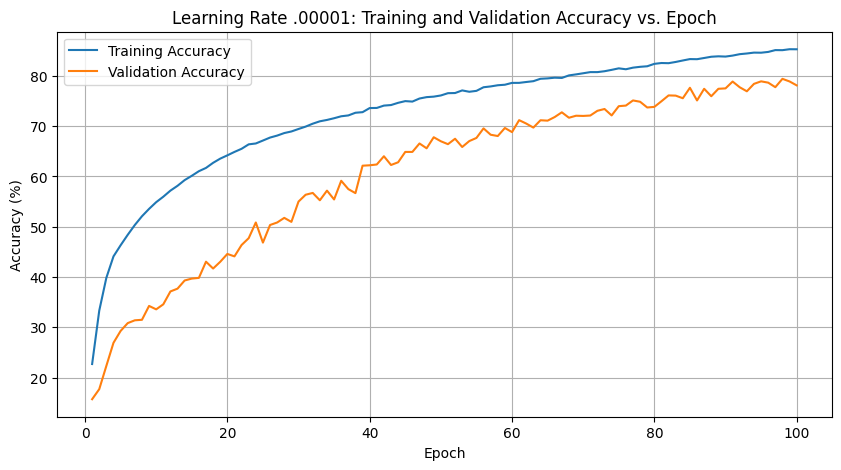

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning Rate .00001: Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
test_loss_list = []
test_num_correct, test_num_samples = 0, 0
model.eval()
test_preds_all = []
test_labels_all = []
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for test_batch_num, (test_images, test_labels) in enumerate(testloader):
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        test_predictions = model(test_images)
        _, test_preds = test_predictions.max(1)
        
        test_preds_all.extend(test_preds.cpu().numpy())
        test_labels_all.extend(test_labels.cpu().numpy())

        test_num_correct += (test_preds == test_labels).sum().item()
        test_num_samples += test_preds.size(0)

        test_loss_list.append(criterion(test_predictions, test_labels))

        for label, prediction in zip(test_labels, test_preds):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

test_accuracy = accuracy_score(test_labels_all, test_preds_all)
test_precision = precision_score(test_labels_all, test_preds_all, average='macro')
test_recall = recall_score(test_labels_all, test_preds_all, average='macro')
test_f1_score = f1_score(test_labels_all, test_preds_all, average='macro')
test_conf_matrix = confusion_matrix(test_labels_all, test_preds_all)

print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1_score:.4f}')
print('Confusion Matrix:')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Test Accuracy: 77.10%
Test Precision: 0.7859
Test Recall: 0.7710
Test F1 Score: 0.7696
Confusion Matrix:
Accuracy for class: plane is 68.7 %
Accuracy for class: car   is 84.8 %
Accuracy for class: bird  is 73.9 %
Accuracy for class: cat   is 58.9 %
Accuracy for class: deer  is 76.4 %
Accuracy for class: dog   is 54.5 %
Accuracy for class: frog  is 92.4 %
Accuracy for class: horse is 77.1 %
Accuracy for class: ship  is 92.2 %
Accuracy for class: truck is 92.1 %


In [14]:
print(f' | Testing Accuracy: {test_accuracy:.2f} | test loss: {sum(test_loss_list)/len(test_loss_list)}')

 | Testing Accuracy: 0.77 | test loss: 0.6782654523849487


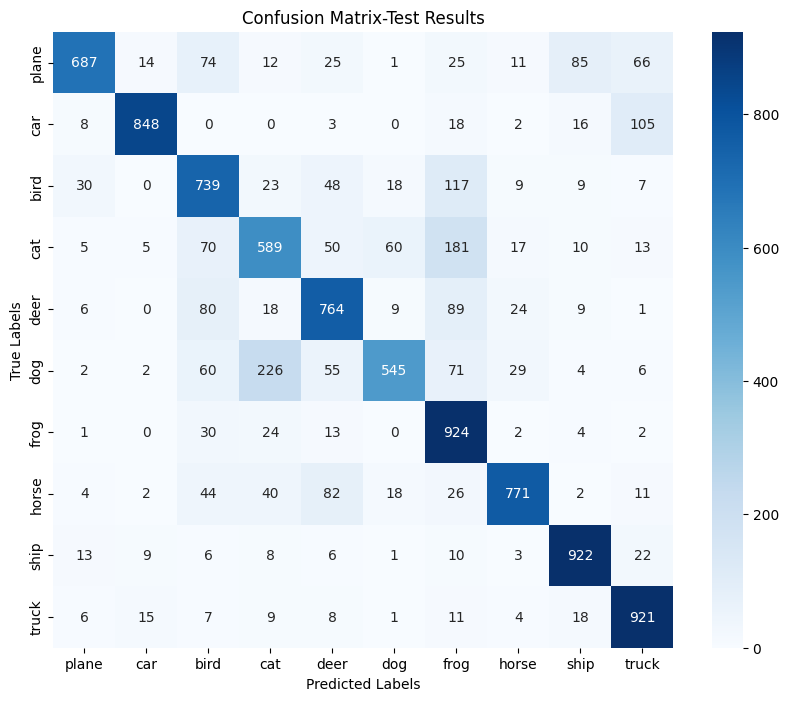

In [15]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-Test Results')
plt.show()
